In [2]:
import numpy as np
import pandas as pd
# matplotlib and seaborn for plotting
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120 #resolution
matplotlib.rcParams['figure.figsize'] = (8,6) #figure size

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
color = sns.color_palette()

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA
import datetime as dt
import scipy.stats
import statsmodels.formula.api as sm
from mpl_toolkits.mplot3d import Axes3D

In [63]:
df = pd.read_csv('Online Retail.csv', encoding = 'unicode_escape')

In [64]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [65]:
df.shape

(541909, 8)

In [66]:
df.dropna(inplace=True)

In [67]:
df_data = df[pd.notnull(df["CustomerID"])]

In [68]:
df_data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [9]:
print("There are {} duplicated values.".format(df_data.duplicated().sum()))
df_data[df_data.duplicated(keep=False)].head(10)

There are 5225 duplicated values.


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
548,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,12/1/2010 11:49,2.95,17920.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,12/1/2010 11:49,2.95,17920.0,United Kingdom


In [69]:
filtered_data = df_data.drop_duplicates()

In [70]:
filtered_data.duplicated().sum()

0

In [71]:
filtered_data = filtered_data[(filtered_data['Quantity']) > 0]

In [13]:
filtered_data.Country.value_counts(normalize=True)[:10]

United Kingdom    0.889225
Germany           0.022985
France            0.021203
EIRE              0.018404
Spain             0.006315
Netherlands       0.006017
Belgium           0.005171
Switzerland       0.004690
Portugal          0.003700
Australia         0.003015
Name: Country, dtype: float64

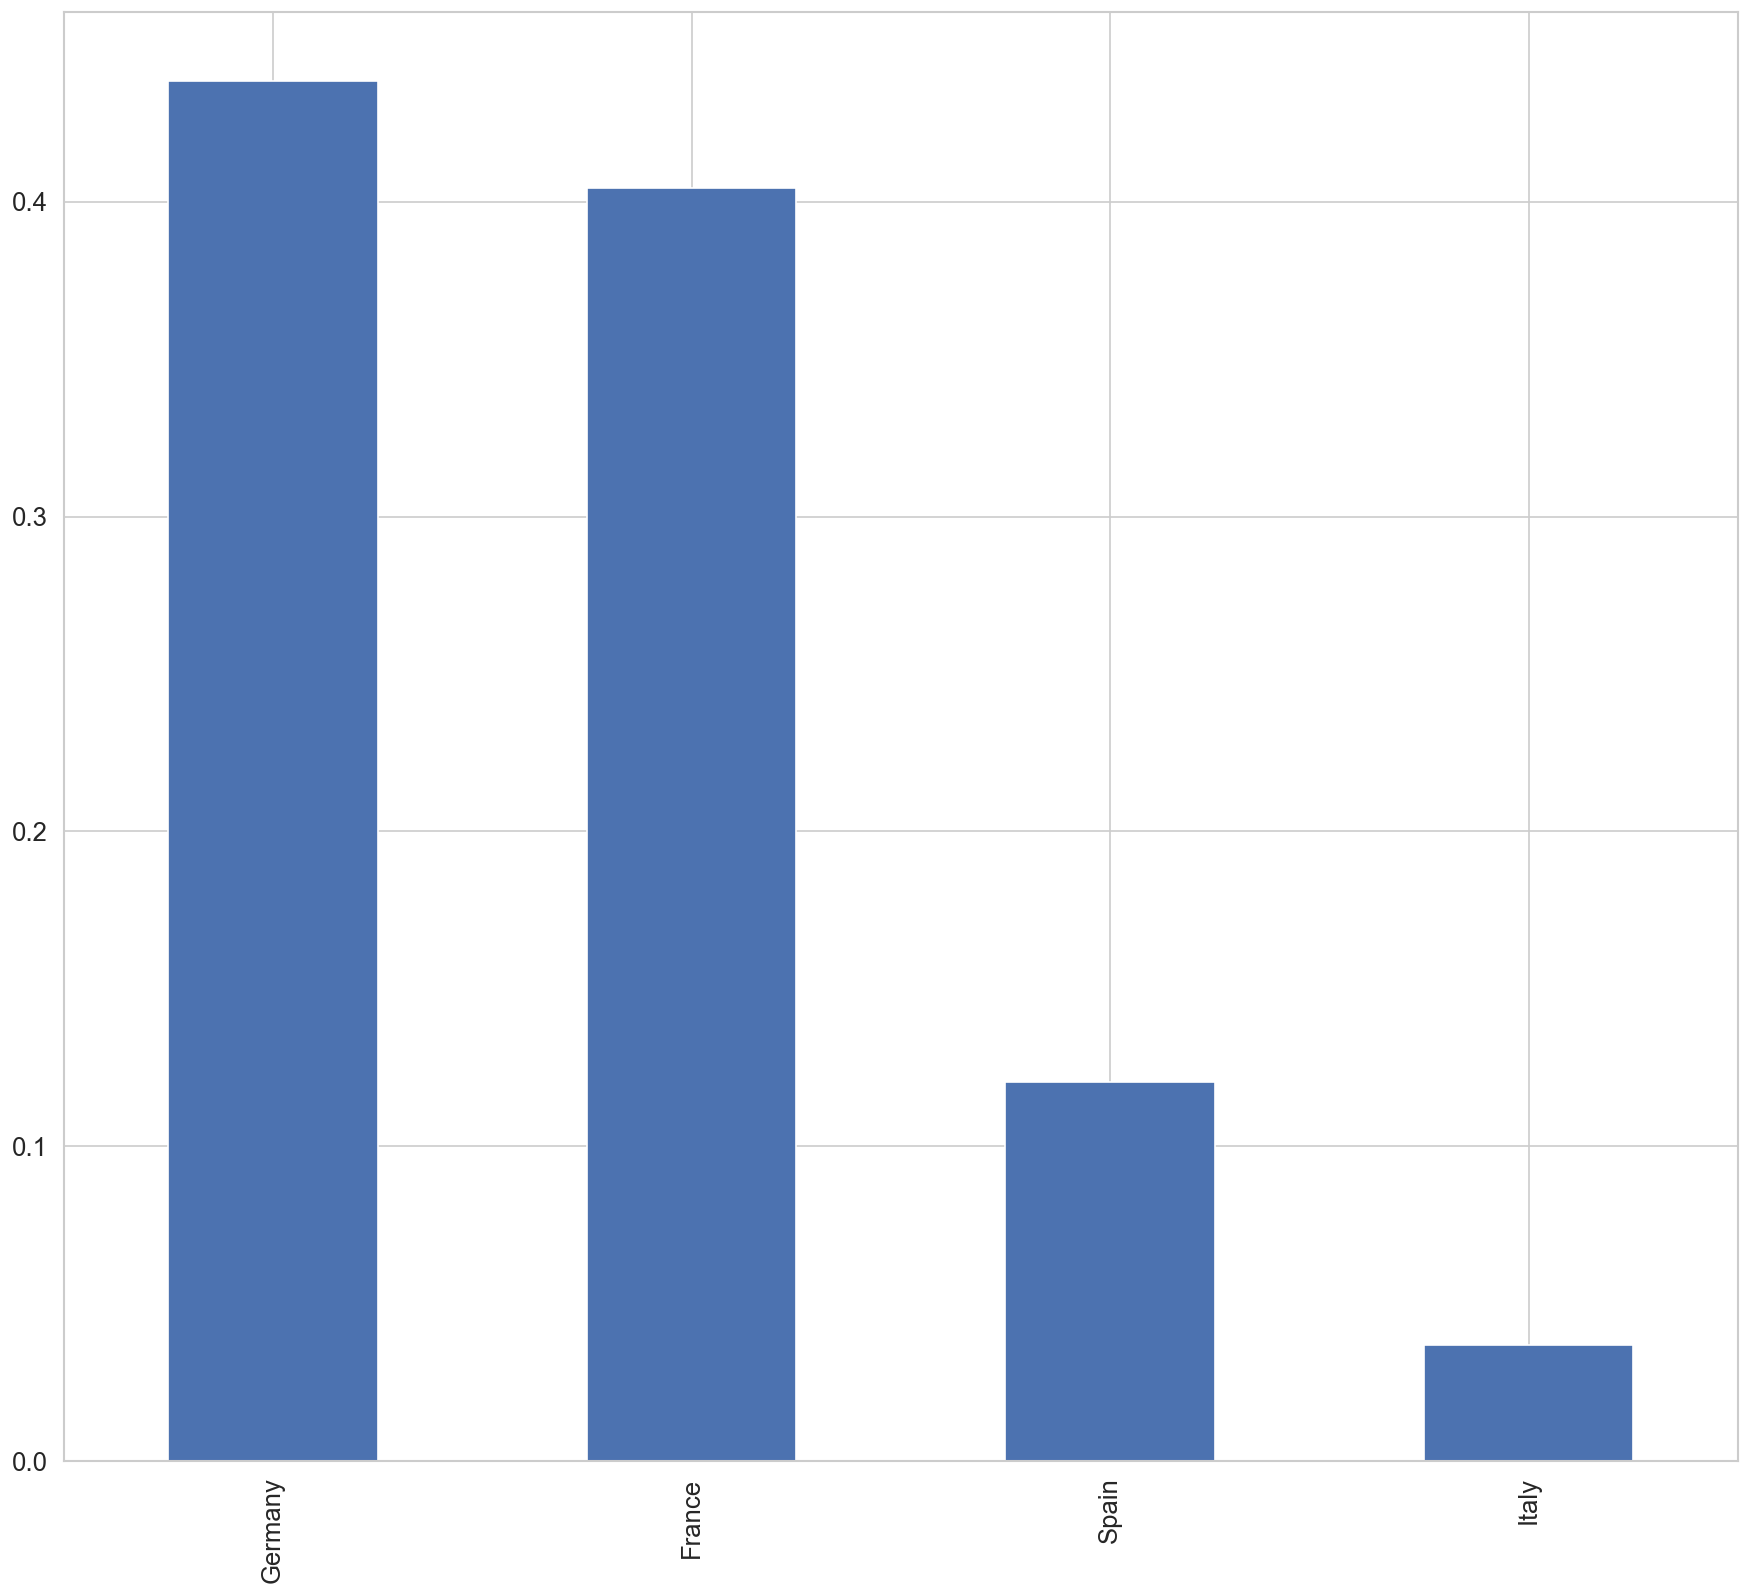

In [281]:
filtered_data.Country.value_counts(normalize=True)[:10].plot(kind="bar")

In [282]:
filtered_data['InvoiceDate'] = pd.to_datetime(filtered_data['InvoiceDate'], format="%m/%d/%Y %H:%M")
#filtered_data['InvoiceDate'] = filtered_data['InvoiceDate'].strftime("%Y/%m/%d %H:%M")

In [283]:
filtered_data.describe()

,Quantity,UnitPrice,CustomerID
count,20592.000000,20592.000000,20592.000000
mean,12.948767,4.048036,12691.995095
std,19.675848,42.856235,532.720777
min,1.000000,0.000000,12349.000000
25%,5.000000,1.250000,12521.000000
50%,10.000000,1.950000,12610.000000
75%,12.000000,3.750000,12682.000000
max,912.000000,4161.060000,17097.000000


In [284]:
filtered_data['TotalPrice'] = filtered_data['Quantity'] * filtered_data['UnitPrice']

In [285]:
filtered_data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64

In [286]:
filtered_data['InvoiceDate'].max(), filtered_data['InvoiceDate'].min()

(Timestamp('2011-12-09 12:50:00'), Timestamp('2010-12-01 08:45:00'))

In [287]:
# assume we are doing this analysis on the next day after this data is generated
TODAY = dt.datetime(2011,12,10)

# testing Recency
least_recency = TODAY - filtered_data['InvoiceDate'].max()
highest_recency = TODAY - filtered_data['InvoiceDate'].min()
least_recency.days, highest_recency.days

(0, 373)

In [288]:
rfm = filtered_data.groupby("CustomerID").agg({"InvoiceDate": lambda date: (TODAY - date.max()).days,
                                        "InvoiceNo": lambda num: num.nunique(),
                                        "TotalPrice": lambda price: price.sum()})

In [289]:
rfm.columns=["recency", "frequency", "monetary"]

In [290]:
rfm.head()

,recency,frequency,monetary
CustomerID,,,
12349.0,18,1,1757.55
12354.0,232,1,1079.40
12413.0,66,3,758.10
12417.0,225,1,436.30
12421.0,15,4,807.04


In [291]:
print("Recency: {} to {}".format(rfm.recency.min(), rfm.recency.max()))
print("Frequency: {} to {}".format(rfm.frequency.min(), rfm.frequency.max()))
print("Monetary: {} to {}".format(rfm.monetary.min(), rfm.monetary.max()))

Recency: 0 to 372
Frequency: 1 to 32
Monetary: 63.0 to 19788.65


In [292]:
rfm["r_quartile"] = pd.qcut(rfm["recency"], 4, ["1","2","3","4"])
rfm["f_quartile"] = pd.qcut(rfm["frequency"], 4, ["3","2","1"], duplicates="drop")
rfm["m_quartile"] = pd.qcut(rfm["monetary"], 4, ["4","3","2","1"])

In [293]:
rfm.head(5)

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,
12349.0,18,1,1757.55,2,3,2
12354.0,232,1,1079.40,4,3,2
12413.0,66,3,758.10,3,2,3
12417.0,225,1,436.30,4,3,4
12421.0,15,4,807.04,1,2,3


In [294]:
rfm["RFM_Score"] = rfm.r_quartile.astype(str)+ rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str)
rfm.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score
CustomerID,,,,,,,
12349.0,18,1,1757.55,2,3,2,232
12354.0,232,1,1079.40,4,3,2,432
12413.0,66,3,758.10,3,2,3,323
12417.0,225,1,436.30,4,3,4,434
12421.0,15,4,807.04,1,2,3,123


In [295]:
group = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(rfm)
    group.append([i, kmeans.inertia_])
groups = pd.DataFrame(group, columns = ['number_of_group', 'inertia'])

In [296]:
groups

,number_of_group,inertia
0,1,2.531489e+09
1,2,7.474619e+08
2,3,2.949309e+08
3,4,1.770541e+08
4,5,1.057891e+08
5,6,6.756775e+07
6,7,4.547137e+07
7,8,3.165493e+07
8,9,2.616780e+07
9,10,2.148674e+07


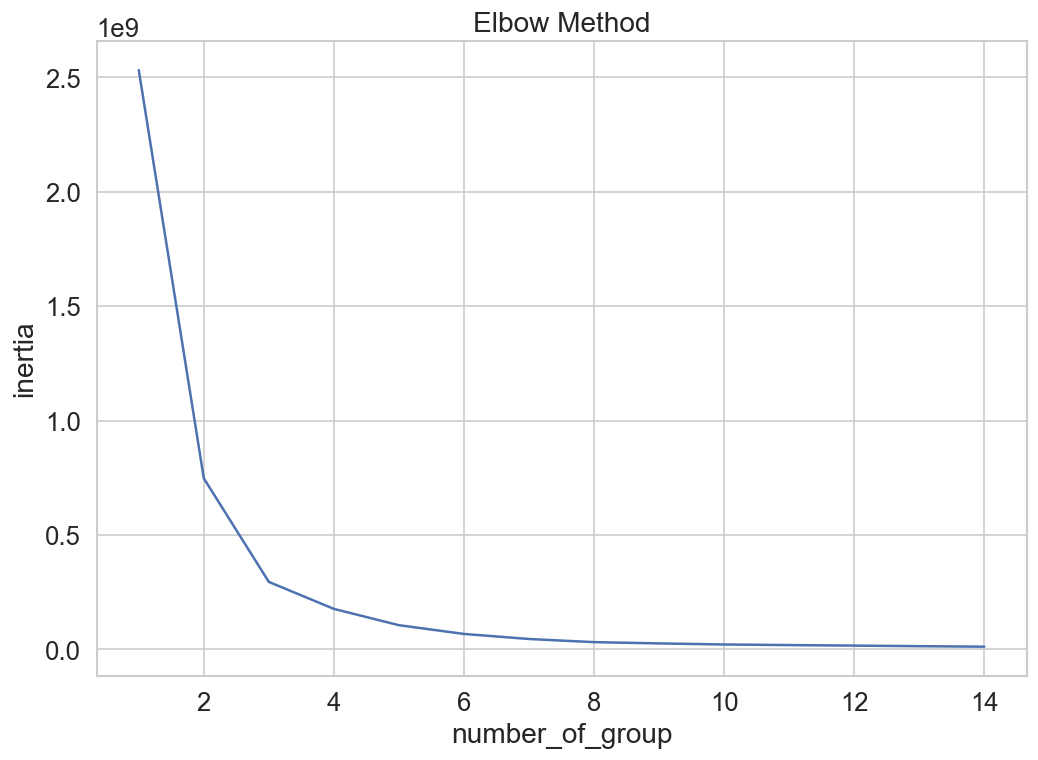

In [297]:
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4, style="whitegrid")
sns.lineplot(data = groups, x = 'number_of_group', y = 'inertia').set(title = "Elbow Method")
plt.show()

In [298]:
def plots_model():    
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    for x in rfm.groups.unique():        
        xs = rfm[rfm.groups == x]['recency']
        zs = rfm[rfm.groups == x]['frequency']
        ys = rfm[rfm.groups == x]['monetary']
        ax.scatter(xs, ys, zs, s=50, alpha=0.6, edgecolors='w', label = x)

    ax.set_xlabel('Recency')
    ax.set_zlabel('Frequency')
    ax.set_ylabel('MonetaryValue')
    plt.title('Visualization of created groups')
    plt.legend()
    plt.show()

In [299]:
model_1 = KMeans(n_clusters=3, init='k-means++', max_iter=300)
groups = model_1.fit_predict(rfm)
rfm['groups'] = groups

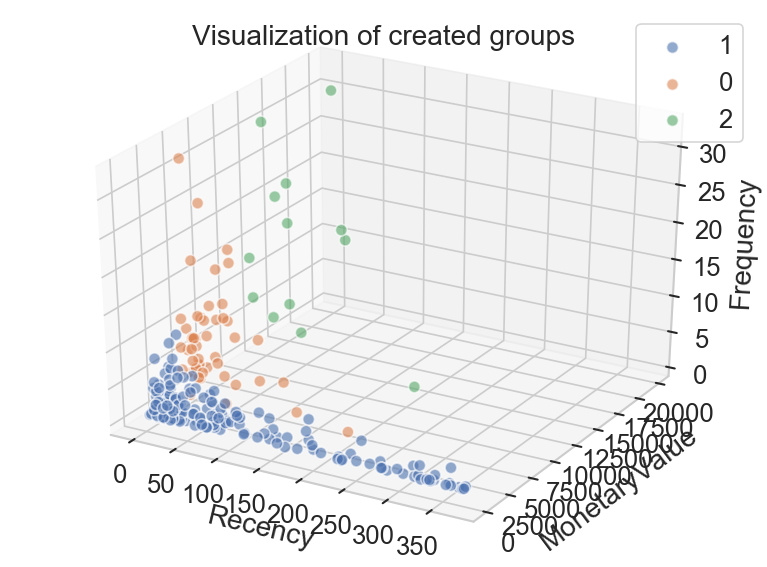

In [300]:
plots_model()

In [301]:
print((rfm.groups.value_counts(normalize = True, sort = True))) 

1    0.720000
0    0.222222
2    0.057778
Name: groups, dtype: float64


In [302]:
rfm.agg(['mean'])

,recency,frequency,monetary,RFM_Score,groups
mean,84.382222,4.328889,2296.242267,inf,0.835556


In [303]:
rfm.groupby('groups').agg(['mean'])

,recency,frequency,monetary
,mean,mean,mean
groups,,,
0,30.980000,8.420000,4330.782800
1,104.962963,2.271605,764.570926
2,33.307692,14.230769,13558.067692


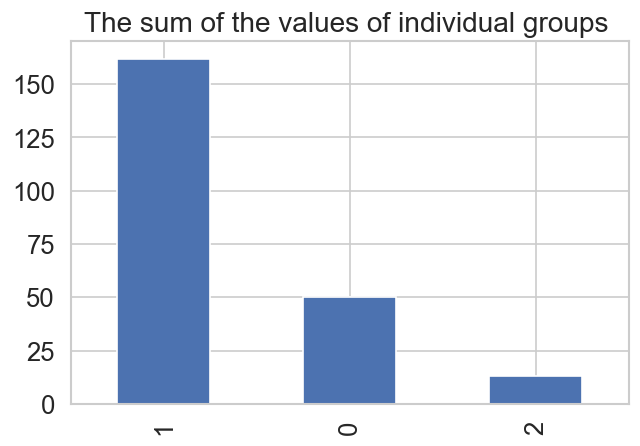

In [304]:
rfm.groups.value_counts().plot(kind='bar', figsize=(6,4), title='The sum of the values of individual groups ');

In [305]:
def name(row):
    if row == 0:
        return 'departing'
    elif row == 1:
        return 'active'
    else:
        return 'inactive'

In [306]:
rfm['SegmentName'] = rfm['groups'].apply(name)

In [307]:
rfm.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score,groups,SegmentName
CustomerID,,,,,,,,,
12349.0,18,1,1757.55,2,3,2,232,1,active
12354.0,232,1,1079.40,4,3,2,432,1,active
12413.0,66,3,758.10,3,2,3,323,1,active
12417.0,225,1,436.30,4,3,4,434,1,active
12421.0,15,4,807.04,1,2,3,123,1,active


In [308]:
rfm_cutted = pd.DataFrame(rfm['RFM_Score'], rfm['SegmentName'])

In [309]:
rfm

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score,groups,SegmentName
CustomerID,,,,,,,,,
12349.0,18,1,1757.55,2,3,2,232,1,active
12354.0,232,1,1079.40,4,3,2,432,1,active
12413.0,66,3,758.10,3,2,3,323,1,active
12417.0,225,1,436.30,4,3,4,434,1,active
12421.0,15,4,807.04,1,2,3,123,1,active
...,...,...,...,...,...,...,...,...,...
13817.0,29,2,382.98,2,3,4,234,1,active
14277.0,15,3,4188.00,1,2,1,121,0,departing
14335.0,16,2,454.86,1,3,3,133,1,active


In [310]:
rfm_t = filtered_data.groupby("CustomerID").agg({"InvoiceDate": lambda date: (TODAY - date.max()).days,
                                        "InvoiceNo": lambda num: num.nunique(),
                                        "TotalPrice": lambda price: price.sum(),
                                        "Country": lambda Country: Country.unique()})

In [311]:
rfm_t

,InvoiceDate,InvoiceNo,TotalPrice,Country
CustomerID,,,,
12349.0,18,1,1757.55,Italy
12354.0,232,1,1079.40,Spain
12413.0,66,3,758.10,France
12417.0,225,1,436.30,Spain
12421.0,15,4,807.04,Spain
...,...,...,...,...
13817.0,29,2,382.98,Germany
14277.0,15,3,4188.00,France
14335.0,16,2,454.86,Germany


In [312]:
df1 = pd.concat([rfm, rfm_t], axis=1)

In [313]:
df1.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score,groups,SegmentName,InvoiceDate,InvoiceNo,TotalPrice,Country
CustomerID,,,,,,,,,,,,,
12349.0,18,1,1757.55,2,3,2,232,1,active,18,1,1757.55,Italy
12354.0,232,1,1079.40,4,3,2,432,1,active,232,1,1079.40,Spain
12413.0,66,3,758.10,3,2,3,323,1,active,66,3,758.10,France
12417.0,225,1,436.30,4,3,4,434,1,active,225,1,436.30,Spain
12421.0,15,4,807.04,1,2,3,123,1,active,15,4,807.04,Spain


E:\Anaconda\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


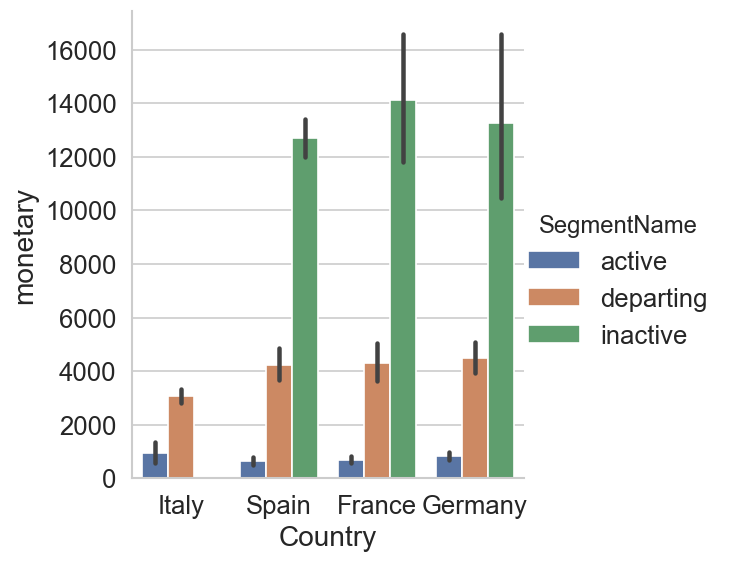

In [314]:
sns.factorplot(y='monetary', x='Country',data=df1,kind="bar" ,hue='SegmentName');

In [315]:
df1.groupby(['Country'])['groups'].size()

Country
France     87
Germany    94
Italy      14
Spain      30
Name: groups, dtype: int64

In [316]:
a = df1.groupby(['Country'])['groups'].value_counts()
a1 = a.unstack()

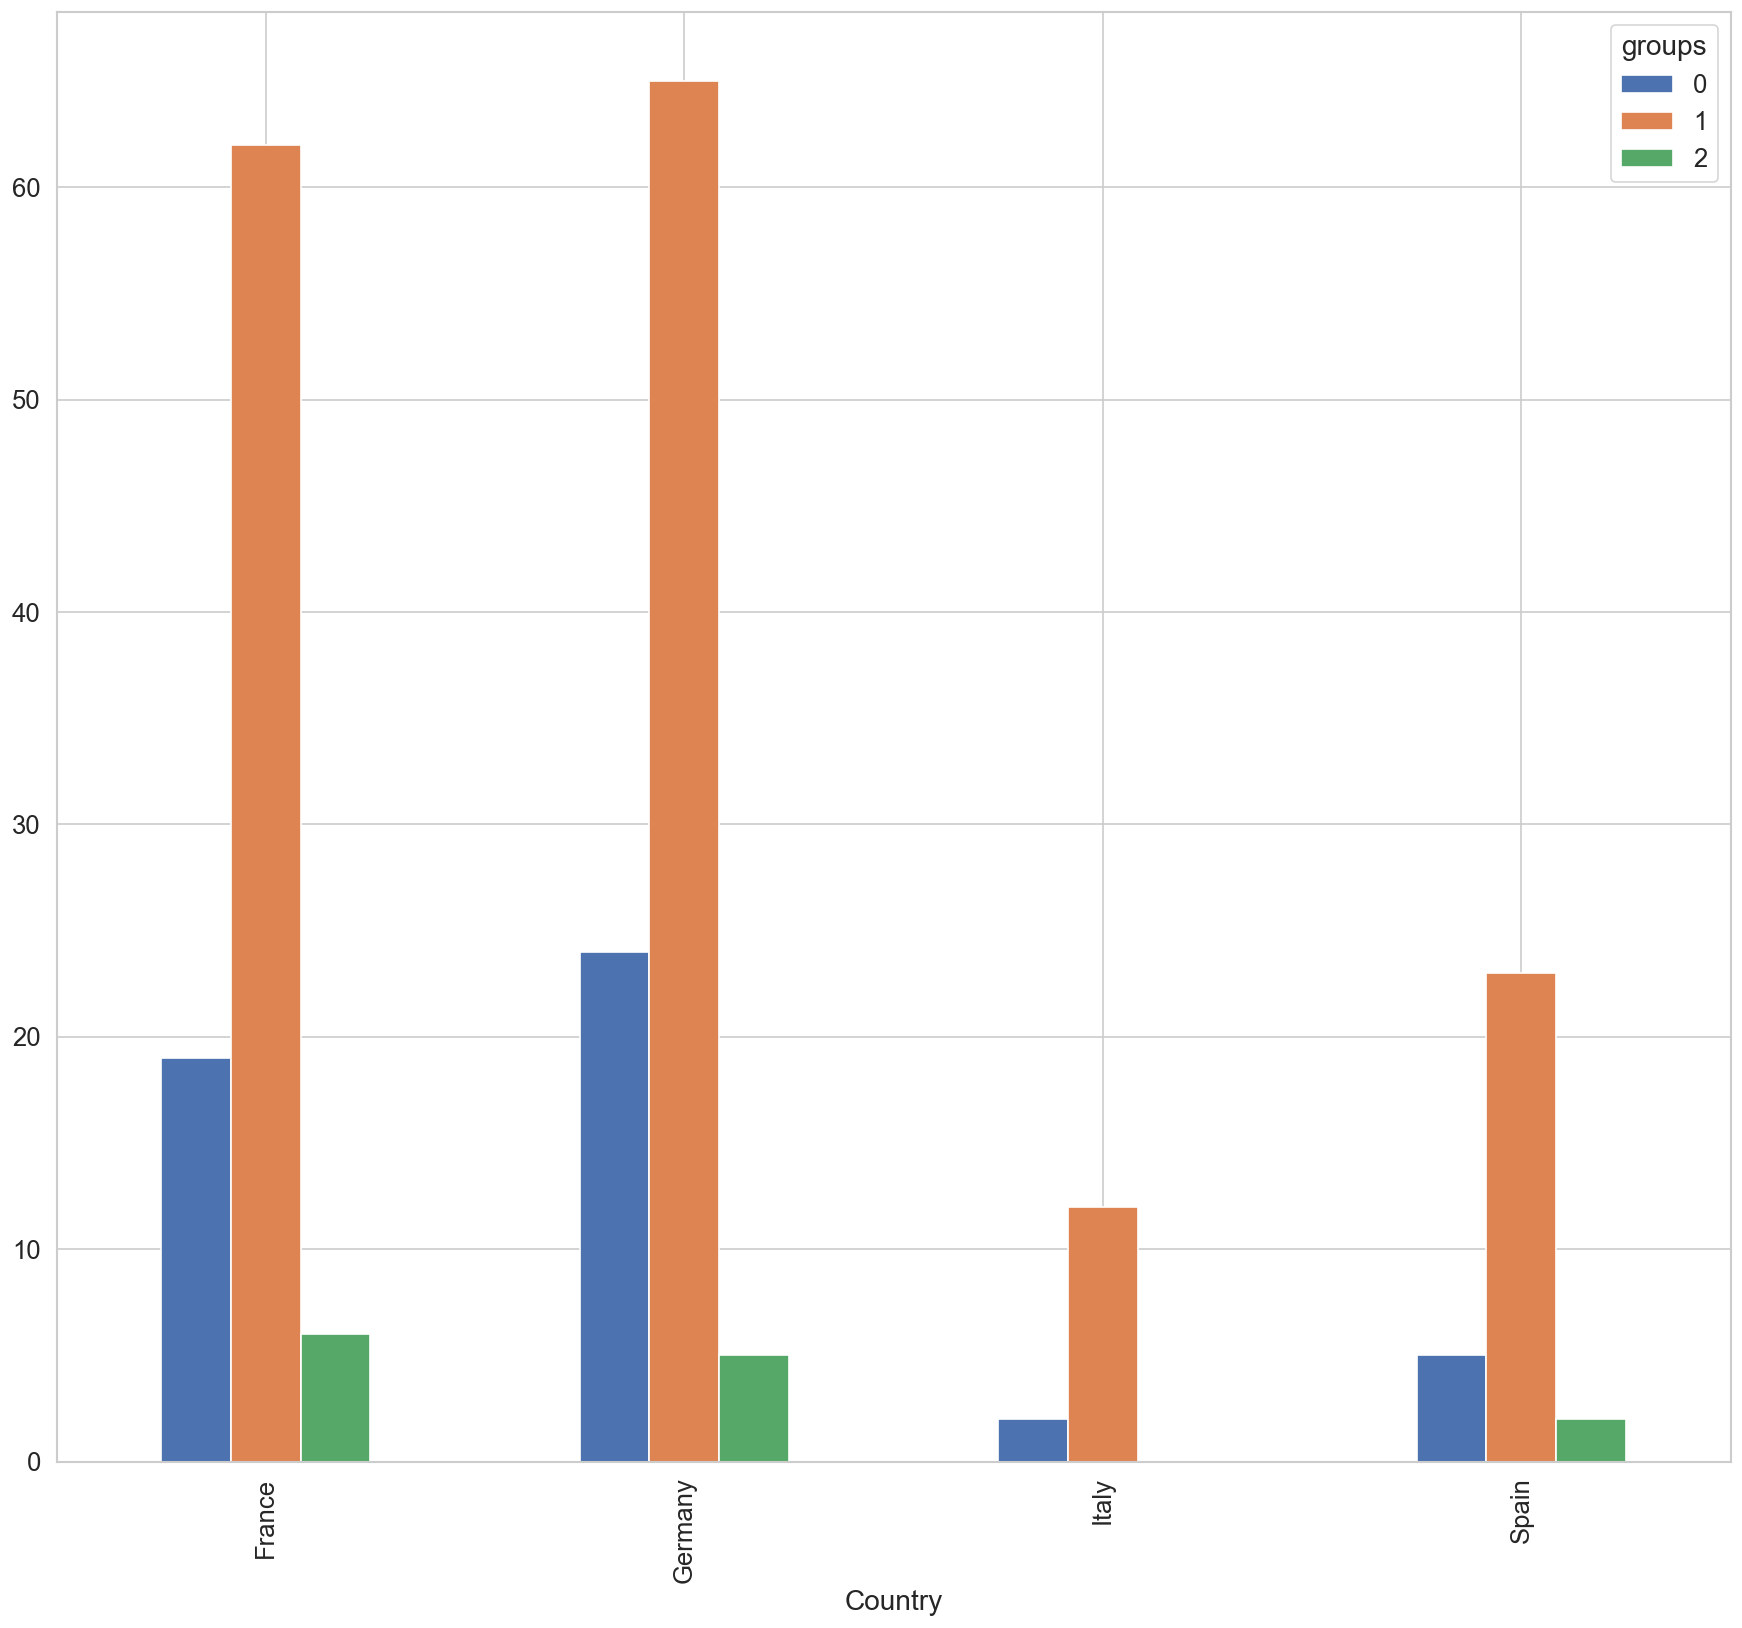

In [317]:
a1.plot(kind="bar")